# Project Goal:
Retinal diseases are known causes of visual impairment and blindness. Retinal optical coherence tomography (OCT) is an imaging technique used in the diagnosis of retinal diseases.It is estimated by National Eye Institute that 2 million Americans aged 40 years and older are affected by AMD (Age-related Macular Degeneration) and an additional 7.3 million with large drusen are at substantial risk of developing AMD. The number of people with AMD is estimated to reach 3 million in 2020. Each year, more than 200,000 people develop CNV (Choroidal Neovascularization), a severe blinding form of advanced AMD. In addition, nearly 750,000 individuals suffer from DME (Diabetic Macular Edema).<br>Timely diagnosis of retinal diseases is crucial and relies on availability of expertise. Given an increase in prevalence of retinal diseases throughout the world, manual methods of diagnosis are unable to keep a pace with demand for screening services. Machine learning and Deep learning for these diagnoses are essential to solving these problems.![title](picture1.png)

## Data Source:	
The dataset was collected from Kaggle website and originally came from Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center. It can be found [here](https://www.kaggle.com/paultimothymooney/kermany2018)


## Preliminary Analysis:
The dataset contains 82,000 images divided into 4 categories CNV, DME, DRUSEN and NORMAL. The first 3 being diseases and the NORMAL being regular retina scans. Initially I decided to work with small subset of 3900 images initially to determine which models perform better. Preliminary analysis involves binary classification meaning the images being classified as diseased vs non-diseased. 
The models used for the preliminary analysis are Logistic Regression, Decision tree, Random Forest classifier, Support Vector Machine, XGBoost and KNeighborsClassifier. The result after optimizing hyperparameters are shown below. ![title](picture.png) 


After looking at the results, I decided to research online and see the previous work that was done on this project. Convolutional Neural Networks seemed to work better for this classification. So I decided with experiment with CNN model. Due to the limitation of computational power, I had to use Kaggle kernel and build a model.

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/oct2017/OCT2017 /train"))


# Any results you write to the current directory are saved as output.

['NORMAL', 'DRUSEN', 'CNV', 'DME']


In [3]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense,Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.externals import joblib
from sklearn.utils import class_weight

In [24]:
names = ['NORMAL', 'DRUSEN', 'CNV', 'DME']
values = []
for name in names:
    img_folder_path = '/Users/yatin/Desktop/Capstone/train/'+name
    dirListing = os.listdir(img_folder_path)
    values.append(len(dirListing))
    print(name, len(dirListing))


NORMAL 26315
DRUSEN 8616
CNV 37205
DME 11348


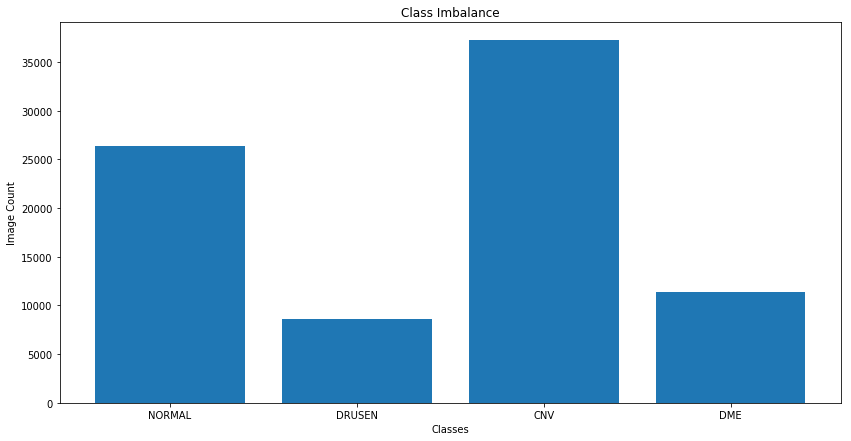

In [27]:
plt.figure(figsize=(14,7))
plt.bar(names,values)
plt.xlabel('Classes')
plt.ylabel('Image Count')
plt.title('Class Imbalance')
plt.show()

## Image Reading and Preprocessing: <br>
Defining a path to extract the images from the train, test and validation folders. In order to process 83484 images, I decided to use Imagedatagenerator function and feed the images by batch as reading all the images all at once was not feasible becuase of the limited memory. It generates batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).The **datagen** function preproceeses the images with the augmentation mentioned below and the **generator** passes the images by specified batch size. <br>
**Data Augmentation:**
Creating a data generator for train, validation and test set to feed the data into model by batches using Imagedatagenerator. Data augmentation is necessary as there is a class imbalance. Neural networks process inputs using small weight values, and inputs with large integer values can casue instability in the neural netowrks and disrupt or slow down the learning process. It is usually good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.
For data augmentation I used

Zoom image by 20%.<br>
Rotation of image by 30 degrees.<br>
Width and Height shift by 20%<br>
Horizontal flip.

### Model Parameters:
For model parameters I started with 10 epochs minimum as it toook almost 7 hours to train the model. The batch size of 35.

In [0]:
train_direct = "../input/oct2017/OCT2017 /train/"
val_direct = "../input/oct2017/OCT2017 /val/"
test_direct = "../input/oct2017/OCT2017 /test/"

In [0]:
num_classes = 4
batch_size = 35
epochs = 16

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        train_direct,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.


In [0]:
val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        val_direct,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='categorical')

Found 32 images belonging to 4 classes.


In [0]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        test_direct,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


## Model Design:<br>

Throughout the model designing process I decided to keep couple parameters constant such as Kernel size(3* 3), optimizer(Adam), activation function(relu) and stride length(2* 2). Thr Adam optimizer usually works well even with little tuning of hyperparameters and also has adaptive moment estimation. 
### Step 1<br>
First basic model had 3 convolutional 2D layers with 128, 64 and 32 filter sizes with data augmentation and image size of 150* 150. The accuracy was worst than regular models.
### Step 2<br>
I decided to include the [class weights](https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras) function as call backs in the model while fitting in order to counter the class-imbalance. It basically assigns the class weights to the respective classes by increasing the instances of the classes with less samples. <br>
### Step 3<br>
I added one more filter at 2nd position with filter size of 128 and decided to add learning rate reduction parameter because it is better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. To keep the advantage of the fast computation time with a high LR, I decreased the LR dynamically every 3 epochs (with patience parameter) if the accuracy of validation set is not improved.
### Step 4<br>
Added batch normalization to every layer. Batch normalization normalizes the ouput from previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This process increases the stability of a neural network. It increases the speed of training and reduces the ability of outlying large weights that will over influence the training process.
### Step 5:<br>
Increasen in the image size from 150* 150 to 250* 250 and addition of one more layer with 256 filter in the begining. I also changed the learning rate parameter to patience of 2. So for every 2 epochs the learning rate decreases if the validation accuracy is not imporved. The accuracy for this model reached 97%.<br>
I increased epochs from 10 to 16 to see if the accuracy improves but it did not affect much. 

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)

In [0]:
model = Sequential()

model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (250,250,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides = (2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides = (2,2)))
model.add(Dropout(0.4))


model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides = (2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides = (2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides = (2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
Optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
model.compile(optimizer= Optimizer,metrics= ['accuracy'], loss = 'categorical_crossentropy')

In [0]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch= train_generator.samples//batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps = 1,
        class_weight = class_weights)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2385/2385 [==============================] - 1933s 810ms/step - loss: 0.9823 - acc: 0.6224 - val_loss: 1.0885 - val_acc: 0.5000
Epoch 2/10
2385/2385 [==============================] - 1727s 724ms/step - loss: 0.7331 - acc: 0.7274 - val_loss: 1.3313 - val_acc: 0.5312
Epoch 3/10
2385/2385 [==============================] - 1711s 717ms/step - loss: 0.6442 - acc: 0.7625 - val_loss: 0.5712 - val_acc: 0.6875
Epoch 4/10
2385/2385 [==============================] - 1730s 725ms/step - loss: 0.4868 - acc: 0.8314 - val_loss: 0.1702 - val_acc: 0.9375
Epoch 5/10
2385/2385 [==============================] - 1723s 722ms/step - loss: 0.3823 - acc: 0.8712 - val_loss: 0.2239 - val_acc: 0.9375
Epoch 6/10
2385/2385 [==============================] - 1716s 719ms/step - loss: 0.3455 - acc: 0.8859 - val_loss: 0.0974 - val_acc: 0.9688
Epoch 7/10
2385/2385 [==============================] - 1716s 720ms/step - loss: 0.3197 - acc: 0.8947 - val_loss: 0.08

In [0]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
result = model.evaluate_generator(test_generator,
steps=STEP_SIZE_TEST+1,
verbose=1)
print(result)

28/28 [==============================] - 4s 141ms/step
[0.06136065281827526, 0.9793388442067076]


In [7]:
prediction = []
classes = []
for i in range(len(test_generator)):
    y_img_batch, y_class_batch = test_generator[0] 
    
    y_predict_proba = model.predict(y_img_batch)    
    
    y_pred = np.argmax(y_predict_proba,-1)
    y_true = np.argmax(y_class_batch,-1)
    
    prediction.extend(y_pred)
    classes.extend(y_true)
    

    
prediction = np.array(prediction)    
classes = np.array(classes)
    

print(sum(prediction==classes)/classes.shape[0])

0.9714285714285714


## Results:<br>
### Confusion matrix and Classification report:
Our model predicted 28 images of DRUSEN as CNV which means the model is bit weak at differentiating CNV from DRUSEN. It is probably because of the class imbalance that DRUSEN images were misclassified becuase DRUSEN had the least number of images. The one up side for the model is it did not classify any of the diseased images as NORMAL.<br>
As a result of this misclassification, classification report indicates CNV and DRUSEN with less f1 score.

In [0]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = pd.Categorical([labels[k] for k in prediction],categories=['CNV','DME','DRUSEN','NORMAL'])

In [0]:
class_name = pd.Categorical([labels[k] for k in classes],categories=['CNV','DME','DRUSEN','NORMAL'])

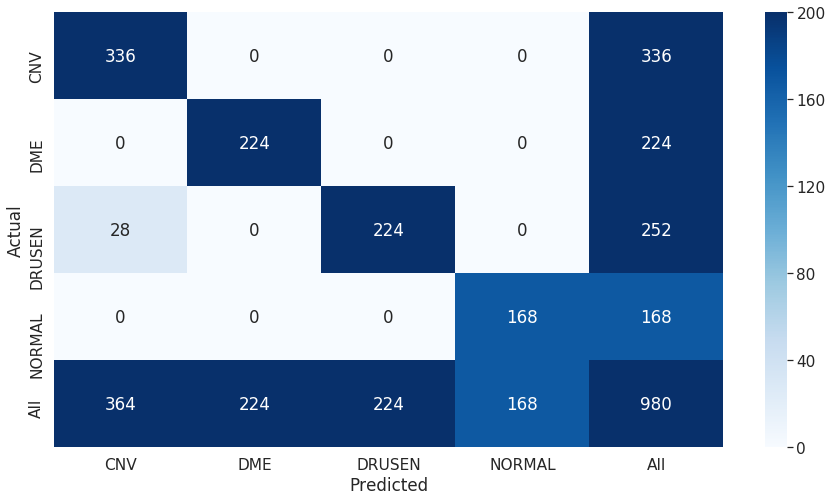

In [13]:
df =pd.crosstab(class_name, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
plt.figure(figsize = [15,8])
sns.set(font_scale=1.4)
sns.heatmap(df,cmap = 'Blues',vmax = 200, vmin = 0,annot=True, fmt = 'g');

In [18]:
print(classification_report(classes,prediction,target_names=['CNV','DME','DRUSEN','NORMAL']))

              precision    recall  f1-score   support

         CNV       0.92      1.00      0.96       336
         DME       1.00      1.00      1.00       224
      DRUSEN       1.00      0.89      0.94       252
      NORMAL       1.00      1.00      1.00       168

    accuracy                           0.97       980
   macro avg       0.98      0.97      0.98       980
weighted avg       0.97      0.97      0.97       980



### Graphs:
The graphs below are accuracy and loss grpahs for training and validation sets over the epochs. Since I set the learning rate reduction for evey 2 epochs, we can see spike in the accuracy of validation set for every 2 epochs and decrease in the loss respectively.

In [0]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

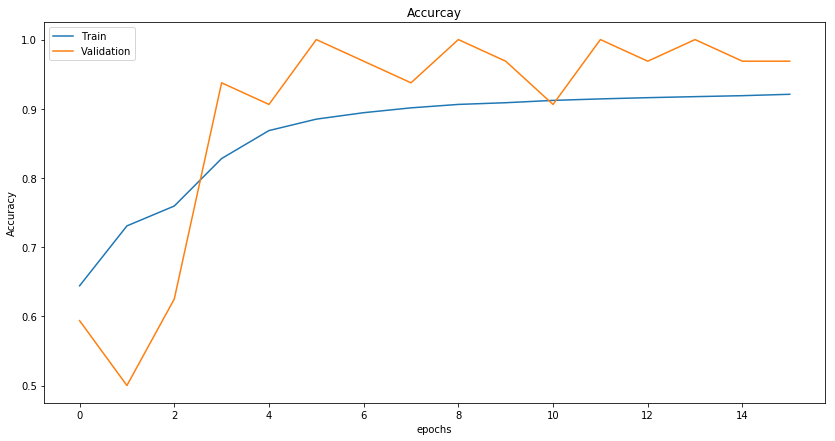

In [0]:
plt.figure(figsize = (14,7))
plt.plot(accuracy, label = 'Train')
plt.plot(val_accuracy, label = 'Validation')
plt.xlabel('epochs')
plt.title('Accurcay')
plt.ylabel('Accuracy')
plt.legend();

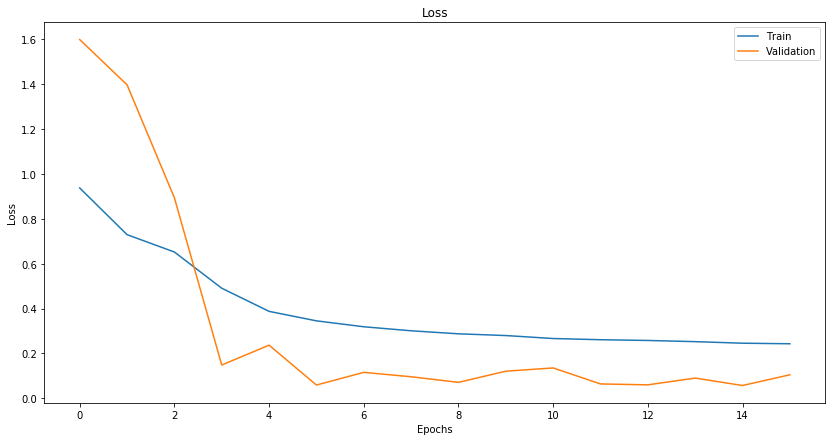

In [0]:
plt.figure(figsize = (14,7))
plt.plot(loss, label = 'Train')
plt.plot(val_loss, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend();